In [1]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange

from tflib.save_images import *

In [2]:
data_dir = './data'
import helper

#helper.download_extract('mnist', data_dir)

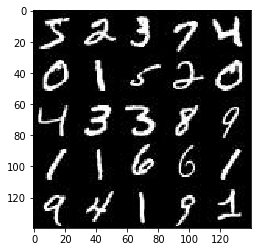

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

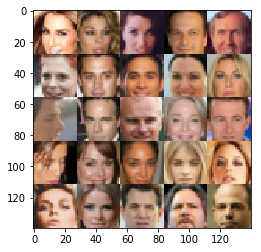

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

"""
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
"""

"\n# Check TensorFlow Version\nassert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)\nprint('TensorFlow Version: {}'.format(tf.__version__))\n\n# Check for a GPU\nif not tf.test.gpu_device_name():\n    warnings.warn('No GPU found. Please use a GPU to train your neural network.')\nelse:\n    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))\n"

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_imgs, inputs_z, learning_rate

## Encoder  

#### the encoder will take the images as input and output a vector of length z_dim

In [6]:
def encoder(images, z_dim, leaky_factor=0.2, reuse=False):
    """
    Create the encoder network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :leaky_factor: leaky_factor for leaky relu layer
    :return: Tensor of output vector (latent z )
    """
    with tf.variable_scope('encoder', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(leaky_factor * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(leaky_factor * x2, x2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(leaky_factor * x3, x3)
        # 4x4x256

        #x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(0.2 * bn4, bn4)
        # 2 * 2 * 512

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        out = tf.layers.dense(flat, z_dim)

        return out

## Decoder  

#### take the latent z as input and output the image we want

In [7]:
def decoder(z, out_channel_dim, leaky_factor=0.2, is_train=True):
    """
    Create the decoder network
    :param images: Tensor of input z
    :param out_channel_dim: the output channel format
    :param leaky_factor: leaky_factor for leaky relu layer
    :param is_train: Boolean if it is train mode or test mode
    :return: Tensor of output vector (latent z )
    """    
    with tf.variable_scope("decoder", reuse= (not is_train)):
        x1 = tf.layers.dense(z, 4 * 4 * 256)
        # reshape it to start the conv stack
        x1 = tf.reshape(x1, [-1, 4, 4, 256])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(leaky_factor * x1, x1)
        # 4 * 4 * 256

        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(leaky_factor * x2, x2)
        # 7 * 7 * 128

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(leaky_factor * x3, x3)
        # 14 * 14 * 64

        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(self.leaky_factor * x4, x4)
        # 24 * 24 * out_channel_dim


        # Output layer  out_chnnale_dim = K = 1 for residual nets
        #out = tf.layers.conv2d_transpose(x3, 1, 5, strides=1, padding='same')
        #out = tf.layers.batch_normalization(out, training=is_train)

        out = tf.tanh(x4)
        return out

## Discriminator  
#### It is used to make the encoder stronger. Discriminate directly on the latent z vector. It is a simple two layer neural network

In [8]:
def discriminator(input_z, leaky_factor=0.2, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input z
    :param leaky_factor: leaky_factor for leaky relu layer
    :param reuse: Boolean if it is train mode or test mode
    :return: tuple of (classification result, logits)
    """     
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.dense(input_z, 1000)
        #x1 = tf.nn.relu(x1)
        x1 = tf.maximum(leaky_factor * x1, x1)

        x2 = tf.layers.dense(x1, 1000)
        #x2 = tf.nn.relu(x2)
        x2 = tf.maximum(leaky_factor * x2, x2)

        logits = tf.layers.dense(x2, 1)
        out = tf.sigmoid(logits)


        return out, logits

### Corruptor 
#### corrupt images as the mask_type and nosie level. First try in-painting

In [9]:
def corrupt(images, mask_type='inpainting',noise=False):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.get_shape().as_list()[1:]
    mu = 0.0
    sigma = 0.1
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    if noise:
        images = tf.add(images, gnoise)
        
    if mask_type == 'inpainting':

        a, b = 2, 2
        #pixFrac = np.random.beta(a,b)
        pixFrac = 0.5
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = tf.multiply(images, mask)
        return result
    # TODO
    #if mask_type == 'compress':
    else:
        return images

### Loss
Implement `model_loss` to build the DAAE for training and calculate the loss.  The function should return a tuple of (discriminator loss, encoder loss, encoder-decoder loss).  Use the following functions you implemented:
- `discriminator(input_z, leaky_factor, reuse=False)`
- `decoder(z, out_channel_dim, leaky_factor, is_train=True)`
- `encoder(images, z_dim, leaky_factor, reuse=False)`

In [10]:
def model_loss(input_real, input_z, z_dim, output_channel_dim, M):
    """
    Get the loss for the discriminator, encoder and decoder
    :param input_real: Images from the real dataset
    :param input_z: Z input from Laplacian distribution
    :param out_channel_dim: The number of channels in the output image
    :param M : how many iterations to sample from p(z|x)
    :return: A tuple of (discriminator loss, encoder loss, recon loss, dis_loss_sum, en_loss_sum, recon_loss_sum)
    """
    corr_images = corrupt(input_real, mask_type='inpainting', noise=False)
    En_corr = encoder(corr_images, z_dim)
    #En_corr = encoder(input_real, z_dim)
    De_corr = decoder(En_corr, output_channel_dim)

    recon_loss = tf.reduce_mean(tf.square(tf.subtract(De_corr, input_real)))
  
    
    """
    fake_z = tf.zeros_like(En_corr, name='fake_z')
    # how to add fake z many times ?
    for i in range(M):
        corr_images = corrupt(input_real, mask_type='inpainting', noise=False)   # implement corruption function
        fake_z += encoder(corr_images, z_dim, reuse=True)

    fake_z /= M
    """
    
    fake_z = En_corr
    fake_z_sum = tf.summary.histogram("fake_z",fake_z)
    d_out_fake, d_logits_fake = discriminator(fake_z)
    d_out_real, d_logits_real = discriminator(input_z, reuse=True)
    
    
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.zeros_like(d_out_fake)))

    d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_real,
                labels=tf.ones_like(d_out_real)))

    dis_loss = d_loss_fake + d_loss_real
    
    
    en_loss = 100* recon_loss + tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.ones_like(d_out_fake)))
    
    dis_loss_sum = tf.summary.scalar("dis_loss", dis_loss)
    recon_loss_sum = tf.summary.scalar("recon_loss", recon_loss)
    en_loss_sum = tf.summary.scalar("en_loss", en_loss)
    
    return dis_loss, en_loss, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum, fake_z_sum
    
    

In [11]:
def model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1, beta2):
    """
    Get optimization operations
    :param dis_loss: Discriminator loss Tensor
    :param en_loss: encoder loss Tensor
    :param recon_loss: reconstruction loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, encoder training operation, recontraining operations)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    dis_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    de_vars = [var for var in t_vars if var.name.startswith('decoder')]
    en_vars = [var for var in t_vars if var.name.startswith('encoder')]
    #ed_vars = de_vars + en_vars
    
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='decoder')):
    de_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(100*recon_loss, var_list=de_vars)
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(dis_loss, var_list=dis_vars)
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='encoder')):
    en_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(en_loss, var_list=en_vars)
    
    return d_train_opt, en_train_opt, de_train_opt




## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import scipy.stats as stats

def sample_from_dis(n_images, z_dim,dis = 'laplacian'):
    if dis == 'laplacian':
        mu = 0.0
        lam = 1.0
        return np.random.laplace(loc=mu, scale=lam, size=[n_images, z_dim])
    elif dis == 'gaussian':
        mu = 0
        lower = -1
        upper = 1
        sigma = 1 / np.sqrt(z_dim)
        sigma = 1
        z = stats.truncnorm.rvs((lower-mu)/sigma, (upper-mu)/sigma, loc=mu, scale=sigma, size=[n_images,z_dim])
        return z
    else:
        return np.random.uniform(-1, 1, size=[n_images, z_dim])


def show_decoder_output(sess, n_images, input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    example_z = sample_from_dis(n_images, z_dim, dis=None)

    samples = sess.run(
        decoder(input_z, out_channel_dim, leaky_factor=0.2, is_train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    
def show_endecoder_output(sess, sample_images, input_real,input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the encoder-decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    #example_z = sample_from_dis(n_images, z_dim, dis=distribution)
    ops = decoder(encoder(corrupt(input_real,mask_type='inpainting',noise=False), z_dim, leaky_factor=0.2, reuse=True), out_channel_dim,
                  leaky_factor=0.2, is_train = False)
    
    corrupt_images = sess.run(corrupt(input_real, mask_type='inpainting',noise=False), feed_dict={input_real:sample_images})
    
    samples = sess.run(
        ops,
        feed_dict={input_real: sample_images})
    
    mse = np.mean((samples - sample_images) ** 2)
    print("######### what? the reconstruction mse is: %2.4f"  % mse)

    images_grid = helper.images_square_grid(samples, image_mode)
    corr_grid = helper.images_square_grid(corrupt_images, image_mode)
    
    pyplot.subplot(121)
    pyplot.imshow(corr_grid, cmap=cmap)
    
    pyplot.subplot(122)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    

### Train
Implement `train` to build and train the DAAE.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, z_dim, output_channel_dim, M)`
- `model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1, beta2)`

Use the `show_decoder_output` to show `decoder` output while you train. Running `show_decoder_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `decoer` output every 100 batches.

In [13]:
import time

checkpoint_dir = './checkpoint'
model_name = "DAAE.model"

def save(saver, sess, checkpoint_dir, model_name, steps):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name),
                        global_step=steps)

    
def load(saver, sess, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        return True
    else:
        return False



def train(epoch_count, batch_size, z_dim, learning_rate, beta1, beta2, M, get_batches, samples, data_shape, data_image_mode):
    """
    Train the DAAE
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :param M: iterations to sample fake_z
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    num_imgs, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    #tf.assign(lr, learning_rate)
    output_channel_dim = image_channels
    
    result = model_loss(input_real, input_z, z_dim, output_channel_dim, M)
    dis_loss, en_loss, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum,fake_z_sum = result
    
    d_train_opt, en_train_opt, de_train_opt = model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1,beta2)
    ITER = 3 # we can train decoder more than 1 time...later~
    steps = 0
    
    recon_sum = tf.summary.merge([recon_loss_sum])
    en_sum = tf.summary.merge([fake_z_sum,en_loss_sum])
    dis_sum = tf.summary.merge([dis_loss_sum])

    saver = tf.train.Saver(max_to_keep=1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter("./logs", sess.graph)
        
        # check if already exists a model
        if load(saver, sess, checkpoint_dir):
            print("""
            We found a existing model and continue to train on it! 
            If you need a new model, delete checkpoint directory""")
        else:
            print("""NOT found a model === Initializing a new one""")
            
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = sample_from_dis(batch_size, z_dim,dis = 'gaussian')

                # Run optimizers
                
                # Update Discriminator network
                _, summary_str = sess.run([d_train_opt, dis_sum],
                        feed_dict={ input_real: batch_images, input_z: batch_z })
                writer.add_summary(summary_str, steps)
                
                    
                # Update the Encoder network
                #for i in range(ITER):
                _, summary_str = sess.run([en_train_opt, en_sum],
                            feed_dict={input_real: batch_images})
                writer.add_summary(summary_str, steps)
                for i in range(ITER):
                # Update Decoder network
                    _, summary_str = sess.run([de_train_opt, recon_sum],
                            feed_dict={ input_real: batch_images})
                writer.add_summary(summary_str, steps)


                
                if steps % 10 == 0:
                    ops = [dis_loss, en_loss,recon_loss]
                    dis_val,en_val,recon_val = sess.run(ops, feed_dict={input_real:batch_images, input_z:batch_z})
                    print("dis_loss: %.8f, en_loss: %.8f, recon_loss: %2.4f" % (dis_val, en_val, recon_val))
                if steps % 100 == 0:
                    #show_decoder_output(sess, show_n_images, input_z, output_channel_dim, data_image_mode)
                    show_endecoder_output(sess, samples, input_real,input_z, output_channel_dim, data_image_mode)
                    
                if steps % 500 == 1:
                    save(saver, sess, checkpoint_dir, model_name, steps)
                    
                    

(59975, 28, 28, 1)
 [*] Reading checkpoints...
NOT found a model === Initializing a new one
dis_loss: 4.90349007, en_loss: 13.11972237, recon_loss: 0.1310
dis_loss: 10.44754601, en_loss: 9.81043530, recon_loss: 0.0981
dis_loss: 6.36622334, en_loss: 8.66235161, recon_loss: 0.0865
dis_loss: 4.40397453, en_loss: 7.35314178, recon_loss: 0.0706
dis_loss: 3.24229050, en_loss: 7.00959778, recon_loss: 0.0587
dis_loss: 2.62218666, en_loss: 5.54550457, recon_loss: 0.0413
dis_loss: 1.99330628, en_loss: 4.90843678, recon_loss: 0.0381
dis_loss: 2.22534227, en_loss: 3.89198732, recon_loss: 0.0303
dis_loss: 2.17089128, en_loss: 3.85288715, recon_loss: 0.0307
dis_loss: 1.97218454, en_loss: 3.34752917, recon_loss: 0.0243
######### what? the reconstruction mse is: 0.1268


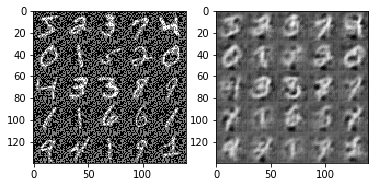

dis_loss: 2.42271566, en_loss: 3.05786252, recon_loss: 0.0244
dis_loss: 2.29227734, en_loss: 2.88753891, recon_loss: 0.0201
dis_loss: 1.97651243, en_loss: 2.88305998, recon_loss: 0.0186
dis_loss: 1.74920046, en_loss: 2.51764345, recon_loss: 0.0164
dis_loss: 2.22159195, en_loss: 2.44790030, recon_loss: 0.0173
dis_loss: 1.99314499, en_loss: 2.73803067, recon_loss: 0.0161
dis_loss: 1.83686543, en_loss: 2.57406712, recon_loss: 0.0156
dis_loss: 1.69444633, en_loss: 2.49981928, recon_loss: 0.0163
dis_loss: 1.89612222, en_loss: 2.28373790, recon_loss: 0.0146
dis_loss: 1.82581604, en_loss: 2.00957155, recon_loss: 0.0124
######### what? the reconstruction mse is: 0.2497


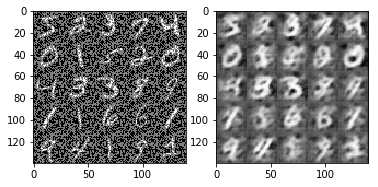

dis_loss: 1.73583865, en_loss: 2.53680468, recon_loss: 0.0153
dis_loss: 1.73768914, en_loss: 2.17585158, recon_loss: 0.0135
dis_loss: 1.66999459, en_loss: 2.71812391, recon_loss: 0.0182
dis_loss: 1.82159960, en_loss: 2.14169407, recon_loss: 0.0138
dis_loss: 1.59778368, en_loss: 2.62764549, recon_loss: 0.0163
dis_loss: 1.54990375, en_loss: 2.28109384, recon_loss: 0.0136
dis_loss: 1.66518092, en_loss: 1.87343395, recon_loss: 0.0107
dis_loss: 1.78396177, en_loss: 1.81052303, recon_loss: 0.0108
dis_loss: 1.55002904, en_loss: 2.22261977, recon_loss: 0.0122
dis_loss: 1.63271177, en_loss: 2.14000535, recon_loss: 0.0125
######### what? the reconstruction mse is: 0.2207


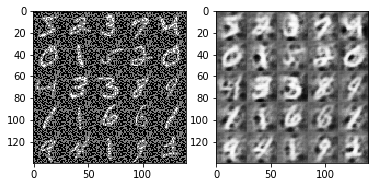

dis_loss: 1.55653584, en_loss: 2.05595756, recon_loss: 0.0121
dis_loss: 1.64003325, en_loss: 2.26318502, recon_loss: 0.0152
dis_loss: 1.53653860, en_loss: 1.89182425, recon_loss: 0.0099
dis_loss: 1.52481794, en_loss: 1.90698862, recon_loss: 0.0097
dis_loss: 1.54519033, en_loss: 2.01419401, recon_loss: 0.0118
dis_loss: 1.48128164, en_loss: 1.93470812, recon_loss: 0.0100
dis_loss: 1.46797132, en_loss: 2.06270123, recon_loss: 0.0115
dis_loss: 1.49393749, en_loss: 1.82549191, recon_loss: 0.0096
dis_loss: 1.43569493, en_loss: 2.00842905, recon_loss: 0.0110
dis_loss: 1.51439953, en_loss: 1.89718986, recon_loss: 0.0103
######### what? the reconstruction mse is: 0.2135


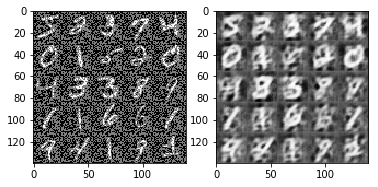

dis_loss: 1.40435410, en_loss: 2.20526838, recon_loss: 0.0121
dis_loss: 1.43875623, en_loss: 1.84913433, recon_loss: 0.0094
dis_loss: 1.42631185, en_loss: 1.97760248, recon_loss: 0.0108
dis_loss: 1.40359950, en_loss: 1.99297595, recon_loss: 0.0108
dis_loss: 1.38370585, en_loss: 2.03636217, recon_loss: 0.0107
dis_loss: 1.45343208, en_loss: 1.83370769, recon_loss: 0.0101
dis_loss: 1.51687729, en_loss: 1.88537765, recon_loss: 0.0101
dis_loss: 1.45878887, en_loss: 2.16227174, recon_loss: 0.0114
dis_loss: 1.42610884, en_loss: 2.02072167, recon_loss: 0.0111
dis_loss: 1.56929350, en_loss: 1.62243772, recon_loss: 0.0089
######### what? the reconstruction mse is: 0.3438


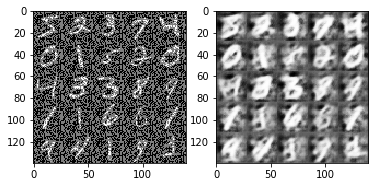

dis_loss: 1.52737880, en_loss: 1.76964080, recon_loss: 0.0101
dis_loss: 1.37357974, en_loss: 1.93598223, recon_loss: 0.0106
dis_loss: 1.37874961, en_loss: 1.94756210, recon_loss: 0.0097
dis_loss: 1.45603752, en_loss: 1.88233113, recon_loss: 0.0102
dis_loss: 1.32737923, en_loss: 2.02738714, recon_loss: 0.0116
dis_loss: 1.37774324, en_loss: 1.69189906, recon_loss: 0.0084
dis_loss: 1.44250453, en_loss: 1.79732132, recon_loss: 0.0099
dis_loss: 1.36886954, en_loss: 1.91168737, recon_loss: 0.0109
dis_loss: 1.31778860, en_loss: 1.74354446, recon_loss: 0.0082
dis_loss: 1.31831121, en_loss: 2.05687475, recon_loss: 0.0112
######### what? the reconstruction mse is: 0.5418


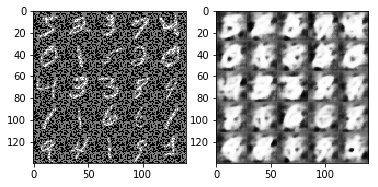

dis_loss: 1.48539960, en_loss: 1.58856368, recon_loss: 0.0089
dis_loss: 1.40071809, en_loss: 1.73138416, recon_loss: 0.0091
dis_loss: 1.38803768, en_loss: 1.87226737, recon_loss: 0.0100
dis_loss: 1.38747811, en_loss: 1.65660787, recon_loss: 0.0088
dis_loss: 1.41361201, en_loss: 1.63152981, recon_loss: 0.0084
dis_loss: 1.42220926, en_loss: 1.77288389, recon_loss: 0.0095
dis_loss: 1.44823956, en_loss: 1.68994427, recon_loss: 0.0091
dis_loss: 1.33952928, en_loss: 2.04170847, recon_loss: 0.0113
dis_loss: 1.34505343, en_loss: 1.88281703, recon_loss: 0.0108
dis_loss: 1.44881248, en_loss: 1.60207307, recon_loss: 0.0083
######### what? the reconstruction mse is: 0.3562


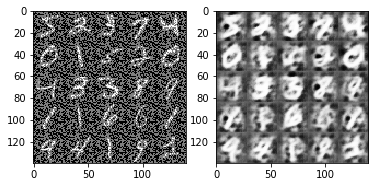

dis_loss: 1.37337017, en_loss: 1.86871493, recon_loss: 0.0101
dis_loss: 1.42860270, en_loss: 1.87588286, recon_loss: 0.0109
dis_loss: 1.37365294, en_loss: 1.71293545, recon_loss: 0.0096
dis_loss: 1.37311125, en_loss: 1.84990263, recon_loss: 0.0101
dis_loss: 1.39697003, en_loss: 1.70319748, recon_loss: 0.0097
dis_loss: 1.47142959, en_loss: 1.62903881, recon_loss: 0.0092
dis_loss: 1.34821486, en_loss: 1.79856360, recon_loss: 0.0099
dis_loss: 1.50658715, en_loss: 1.50779080, recon_loss: 0.0084
dis_loss: 1.38066375, en_loss: 1.90412581, recon_loss: 0.0113
dis_loss: 1.49262297, en_loss: 1.57046223, recon_loss: 0.0086
######### what? the reconstruction mse is: 0.3450


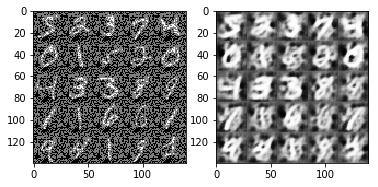

dis_loss: 1.39206469, en_loss: 1.76831985, recon_loss: 0.0096
dis_loss: 1.42214930, en_loss: 1.62916636, recon_loss: 0.0094
dis_loss: 1.37518764, en_loss: 1.75715470, recon_loss: 0.0097
dis_loss: 1.43399513, en_loss: 1.64838696, recon_loss: 0.0097
dis_loss: 1.42824769, en_loss: 1.85366464, recon_loss: 0.0117
dis_loss: 1.28281903, en_loss: 1.78846002, recon_loss: 0.0089
dis_loss: 1.32315683, en_loss: 1.80057883, recon_loss: 0.0098
dis_loss: 1.35540271, en_loss: 1.56680393, recon_loss: 0.0082
dis_loss: 1.41186976, en_loss: 1.62009537, recon_loss: 0.0096
dis_loss: 1.47111082, en_loss: 1.54452181, recon_loss: 0.0087
######### what? the reconstruction mse is: 0.3597


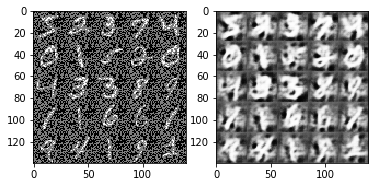

dis_loss: 1.45540619, en_loss: 1.86775053, recon_loss: 0.0119
dis_loss: 1.48870254, en_loss: 1.59325552, recon_loss: 0.0094
dis_loss: 1.45138860, en_loss: 1.70995498, recon_loss: 0.0098
dis_loss: 1.42589223, en_loss: 1.61358392, recon_loss: 0.0093
dis_loss: 1.40478468, en_loss: 1.82474530, recon_loss: 0.0108
dis_loss: 1.50092721, en_loss: 1.54866648, recon_loss: 0.0092
dis_loss: 1.36688840, en_loss: 1.53853559, recon_loss: 0.0082
dis_loss: 1.56255376, en_loss: 1.33390856, recon_loss: 0.0076
dis_loss: 1.44101846, en_loss: 1.71855485, recon_loss: 0.0106
dis_loss: 1.37842071, en_loss: 1.79055023, recon_loss: 0.0104
######### what? the reconstruction mse is: 0.4567


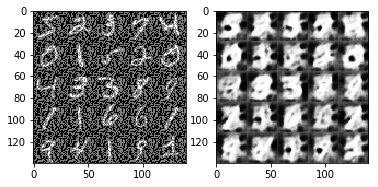

dis_loss: 1.41244555, en_loss: 1.59944415, recon_loss: 0.0091
dis_loss: 1.51464784, en_loss: 1.51327109, recon_loss: 0.0090
dis_loss: 1.34707403, en_loss: 1.67641711, recon_loss: 0.0088
dis_loss: 1.41090512, en_loss: 1.50226021, recon_loss: 0.0083
dis_loss: 1.40719891, en_loss: 1.59403980, recon_loss: 0.0095
dis_loss: 1.49917722, en_loss: 1.59433651, recon_loss: 0.0095
dis_loss: 1.45154166, en_loss: 1.44483280, recon_loss: 0.0079
dis_loss: 1.39005268, en_loss: 1.58928442, recon_loss: 0.0093
dis_loss: 1.35661983, en_loss: 1.57004154, recon_loss: 0.0082
dis_loss: 1.44921231, en_loss: 1.61971378, recon_loss: 0.0088
######### what? the reconstruction mse is: 0.3479


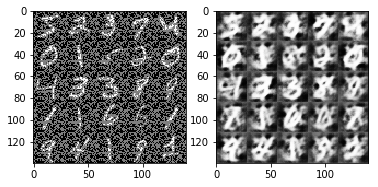

dis_loss: 1.41392553, en_loss: 1.56443608, recon_loss: 0.0089
dis_loss: 1.54300952, en_loss: 1.44978476, recon_loss: 0.0086
dis_loss: 1.38982415, en_loss: 1.88321137, recon_loss: 0.0120
dis_loss: 1.42989922, en_loss: 1.68370771, recon_loss: 0.0099
dis_loss: 1.38546968, en_loss: 1.57231140, recon_loss: 0.0089
dis_loss: 1.30601215, en_loss: 1.48504376, recon_loss: 0.0079
dis_loss: 1.46726799, en_loss: 1.47978234, recon_loss: 0.0088
dis_loss: 1.29920661, en_loss: 1.81051278, recon_loss: 0.0101
dis_loss: 1.50889289, en_loss: 1.41794825, recon_loss: 0.0086
dis_loss: 1.45456719, en_loss: 1.44656396, recon_loss: 0.0082
######### what? the reconstruction mse is: 0.4048


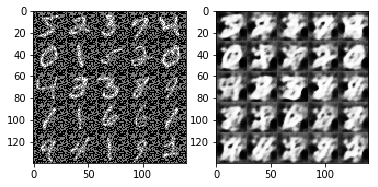

dis_loss: 1.52430785, en_loss: 1.42011905, recon_loss: 0.0083
dis_loss: 1.48578644, en_loss: 1.43663466, recon_loss: 0.0082
dis_loss: 1.46894455, en_loss: 1.50039101, recon_loss: 0.0089
dis_loss: 1.37238836, en_loss: 1.51130223, recon_loss: 0.0086
dis_loss: 1.39233780, en_loss: 1.56667233, recon_loss: 0.0093
dis_loss: 1.54482031, en_loss: 1.25474167, recon_loss: 0.0072
dis_loss: 1.56863916, en_loss: 1.53866374, recon_loss: 0.0092
dis_loss: 1.39634383, en_loss: 1.56717443, recon_loss: 0.0090
dis_loss: 1.49772823, en_loss: 1.52342713, recon_loss: 0.0097
dis_loss: 1.55111957, en_loss: 1.52167857, recon_loss: 0.0094
######### what? the reconstruction mse is: 0.4428


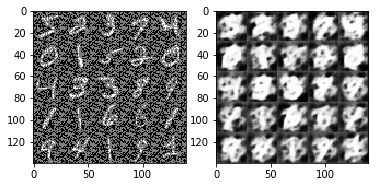

dis_loss: 1.33164322, en_loss: 1.53608298, recon_loss: 0.0080
dis_loss: 1.52282715, en_loss: 1.51238608, recon_loss: 0.0100
dis_loss: 1.27520847, en_loss: 1.76112175, recon_loss: 0.0092
dis_loss: 1.48460972, en_loss: 1.34678793, recon_loss: 0.0077
dis_loss: 1.33950889, en_loss: 1.52034009, recon_loss: 0.0083
dis_loss: 1.45206404, en_loss: 1.52425814, recon_loss: 0.0087
dis_loss: 1.42330492, en_loss: 1.53469801, recon_loss: 0.0089
dis_loss: 1.49678671, en_loss: 1.47751570, recon_loss: 0.0092
dis_loss: 1.48322070, en_loss: 1.40359211, recon_loss: 0.0079
dis_loss: 1.42646933, en_loss: 1.62257481, recon_loss: 0.0094
######### what? the reconstruction mse is: 0.2883


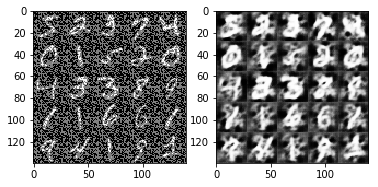

dis_loss: 1.46740985, en_loss: 1.46504128, recon_loss: 0.0088
dis_loss: 1.39940763, en_loss: 1.62035275, recon_loss: 0.0096
dis_loss: 1.35026610, en_loss: 1.66156411, recon_loss: 0.0101
dis_loss: 1.52706468, en_loss: 1.40555096, recon_loss: 0.0088
dis_loss: 1.48299468, en_loss: 1.44784355, recon_loss: 0.0087
dis_loss: 1.36206806, en_loss: 1.50080061, recon_loss: 0.0084
dis_loss: 1.48062491, en_loss: 1.40098214, recon_loss: 0.0080
dis_loss: 1.43838906, en_loss: 1.46983361, recon_loss: 0.0084
dis_loss: 1.39680099, en_loss: 1.70526624, recon_loss: 0.0104
dis_loss: 1.47930741, en_loss: 1.46203840, recon_loss: 0.0081
######### what? the reconstruction mse is: 0.4546


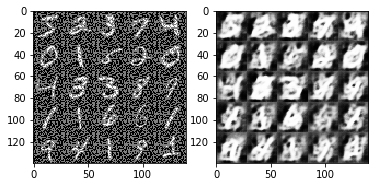

dis_loss: 1.44503260, en_loss: 1.45110822, recon_loss: 0.0084
dis_loss: 1.39232874, en_loss: 1.50074482, recon_loss: 0.0084
dis_loss: 1.48860908, en_loss: 1.55474067, recon_loss: 0.0095
dis_loss: 1.43510711, en_loss: 1.56506085, recon_loss: 0.0092
dis_loss: 1.38508058, en_loss: 1.45545566, recon_loss: 0.0080
dis_loss: 1.49743199, en_loss: 1.37749541, recon_loss: 0.0082
dis_loss: 1.43844891, en_loss: 1.27355003, recon_loss: 0.0070
dis_loss: 1.23776126, en_loss: 1.54129875, recon_loss: 0.0079
dis_loss: 1.48393846, en_loss: 1.44552279, recon_loss: 0.0090
dis_loss: 1.43107259, en_loss: 1.43409181, recon_loss: 0.0085
######### what? the reconstruction mse is: 0.3674


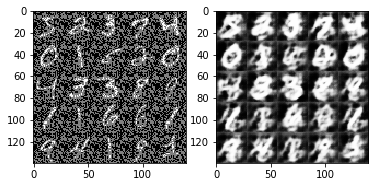

dis_loss: 1.56775999, en_loss: 1.27306890, recon_loss: 0.0072
dis_loss: 1.31808662, en_loss: 1.56968176, recon_loss: 0.0087
dis_loss: 1.44474769, en_loss: 1.40622628, recon_loss: 0.0081
dis_loss: 1.39479613, en_loss: 1.46643329, recon_loss: 0.0084
dis_loss: 1.45250309, en_loss: 1.40753198, recon_loss: 0.0083
dis_loss: 1.35079575, en_loss: 1.43515754, recon_loss: 0.0081
dis_loss: 1.26487887, en_loss: 1.50531590, recon_loss: 0.0083
dis_loss: 1.47467875, en_loss: 1.37803507, recon_loss: 0.0079
dis_loss: 1.41951096, en_loss: 1.45708799, recon_loss: 0.0086
dis_loss: 1.26363015, en_loss: 1.56001091, recon_loss: 0.0081
######### what? the reconstruction mse is: 0.4485


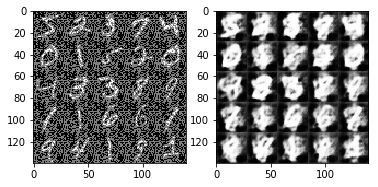

dis_loss: 1.47285819, en_loss: 1.41209590, recon_loss: 0.0087
dis_loss: 1.15839791, en_loss: 1.66002631, recon_loss: 0.0084
dis_loss: 1.33633745, en_loss: 1.43164039, recon_loss: 0.0080
dis_loss: 1.38942361, en_loss: 1.66719306, recon_loss: 0.0108
dis_loss: 1.35887885, en_loss: 1.51450014, recon_loss: 0.0083
dis_loss: 1.50583291, en_loss: 1.43341947, recon_loss: 0.0089
dis_loss: 1.48691082, en_loss: 1.51444507, recon_loss: 0.0091
dis_loss: 1.44093001, en_loss: 1.48845637, recon_loss: 0.0088
dis_loss: 1.28798711, en_loss: 1.60070419, recon_loss: 0.0089
dis_loss: 1.51977193, en_loss: 1.33965135, recon_loss: 0.0082
######### what? the reconstruction mse is: 0.3671


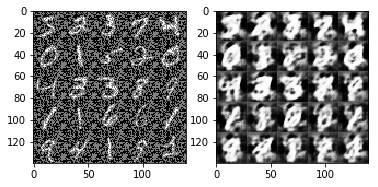

dis_loss: 1.38203871, en_loss: 1.51242578, recon_loss: 0.0085
dis_loss: 1.48643947, en_loss: 1.46243119, recon_loss: 0.0093
dis_loss: 1.65171635, en_loss: 1.27763486, recon_loss: 0.0080
dis_loss: 1.55198503, en_loss: 1.52663207, recon_loss: 0.0096
dis_loss: 1.42288005, en_loss: 1.26795924, recon_loss: 0.0072
dis_loss: 1.07459080, en_loss: 1.95758724, recon_loss: 0.0105
dis_loss: 1.24624979, en_loss: 1.76606405, recon_loss: 0.0111
dis_loss: 1.27616739, en_loss: 1.61799216, recon_loss: 0.0087
dis_loss: 1.34857178, en_loss: 1.47568488, recon_loss: 0.0078
dis_loss: 1.26065123, en_loss: 1.46510458, recon_loss: 0.0078
######### what? the reconstruction mse is: 0.3320


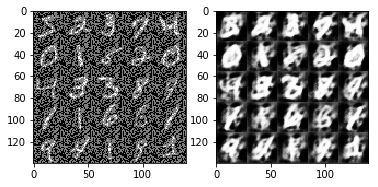

dis_loss: 1.51791239, en_loss: 1.38323021, recon_loss: 0.0087
dis_loss: 1.34785831, en_loss: 1.60424256, recon_loss: 0.0092
dis_loss: 1.44492364, en_loss: 1.47349787, recon_loss: 0.0080
dis_loss: 1.32066286, en_loss: 1.43046260, recon_loss: 0.0071
dis_loss: 1.38270760, en_loss: 1.35787964, recon_loss: 0.0077
dis_loss: 1.30869150, en_loss: 1.50546861, recon_loss: 0.0087
dis_loss: 1.32824254, en_loss: 1.44620228, recon_loss: 0.0074
dis_loss: 1.43726850, en_loss: 1.38899112, recon_loss: 0.0076
dis_loss: 1.37357402, en_loss: 1.46861005, recon_loss: 0.0085
dis_loss: 1.28983486, en_loss: 1.58628619, recon_loss: 0.0088
######### what? the reconstruction mse is: 0.3674


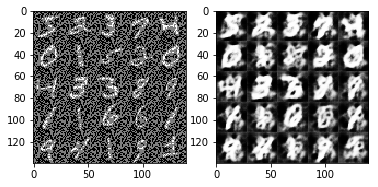

dis_loss: 1.45867014, en_loss: 1.49111271, recon_loss: 0.0087
dis_loss: 1.22900140, en_loss: 1.54126906, recon_loss: 0.0080
dis_loss: 1.35920644, en_loss: 1.47533000, recon_loss: 0.0082
dis_loss: 1.32990241, en_loss: 1.53638601, recon_loss: 0.0083
dis_loss: 1.24197221, en_loss: 1.56528068, recon_loss: 0.0083
dis_loss: 1.29722142, en_loss: 1.56218863, recon_loss: 0.0086
dis_loss: 1.34816587, en_loss: 1.31240487, recon_loss: 0.0069
dis_loss: 1.26427317, en_loss: 1.61922812, recon_loss: 0.0085
dis_loss: 1.35854602, en_loss: 1.64585972, recon_loss: 0.0098
dis_loss: 1.48736465, en_loss: 1.50775313, recon_loss: 0.0092
######### what? the reconstruction mse is: 0.3933


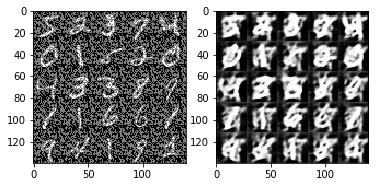

dis_loss: 1.38444877, en_loss: 1.34938514, recon_loss: 0.0065
dis_loss: 1.40232277, en_loss: 1.53602958, recon_loss: 0.0089
dis_loss: 1.40068436, en_loss: 1.44298220, recon_loss: 0.0081
dis_loss: 1.18267310, en_loss: 1.71952605, recon_loss: 0.0096
dis_loss: 1.34221995, en_loss: 1.42682099, recon_loss: 0.0080
dis_loss: 1.24959075, en_loss: 1.71860945, recon_loss: 0.0096
dis_loss: 1.32168758, en_loss: 1.42996073, recon_loss: 0.0078
dis_loss: 1.30507421, en_loss: 1.52326751, recon_loss: 0.0082
dis_loss: 1.35335803, en_loss: 1.37641954, recon_loss: 0.0070
dis_loss: 1.22717834, en_loss: 1.79530525, recon_loss: 0.0106
######### what? the reconstruction mse is: 0.5060


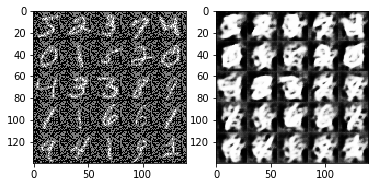

dis_loss: 1.42039418, en_loss: 1.42599416, recon_loss: 0.0078
dis_loss: 1.20744777, en_loss: 1.52269077, recon_loss: 0.0080
dis_loss: 1.30512178, en_loss: 1.72914922, recon_loss: 0.0099
dis_loss: 1.36120486, en_loss: 1.57906628, recon_loss: 0.0094
dis_loss: 1.28577983, en_loss: 1.37827492, recon_loss: 0.0068
dis_loss: 1.43358016, en_loss: 1.51690614, recon_loss: 0.0086
dis_loss: 1.33415961, en_loss: 1.45243895, recon_loss: 0.0074
dis_loss: 1.20743370, en_loss: 1.81048453, recon_loss: 0.0107
dis_loss: 1.40672374, en_loss: 1.44515944, recon_loss: 0.0086
dis_loss: 1.30841875, en_loss: 1.66467738, recon_loss: 0.0099
######### what? the reconstruction mse is: 0.3774


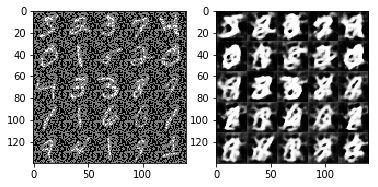

dis_loss: 1.37487292, en_loss: 1.37042856, recon_loss: 0.0078
dis_loss: 1.26306105, en_loss: 1.65409780, recon_loss: 0.0083
dis_loss: 1.37299871, en_loss: 1.49785042, recon_loss: 0.0081
dis_loss: 1.22439981, en_loss: 1.65662849, recon_loss: 0.0081
dis_loss: 1.34715104, en_loss: 1.48418593, recon_loss: 0.0079
dis_loss: 1.36379039, en_loss: 1.32471704, recon_loss: 0.0067
dis_loss: 1.19287610, en_loss: 1.55765438, recon_loss: 0.0084
dis_loss: 1.28400862, en_loss: 1.41692066, recon_loss: 0.0073
dis_loss: 1.39121449, en_loss: 1.35184121, recon_loss: 0.0067
dis_loss: 1.15914881, en_loss: 1.63487792, recon_loss: 0.0084
######### what? the reconstruction mse is: 0.3223


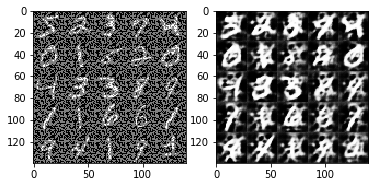

dis_loss: 1.26717067, en_loss: 1.50305223, recon_loss: 0.0081
dis_loss: 1.43901658, en_loss: 1.39433908, recon_loss: 0.0080
dis_loss: 1.29126370, en_loss: 1.43107116, recon_loss: 0.0071
dis_loss: 1.41692376, en_loss: 1.41120708, recon_loss: 0.0077
dis_loss: 1.14312768, en_loss: 1.50261688, recon_loss: 0.0075
dis_loss: 1.34165359, en_loss: 1.46417511, recon_loss: 0.0077
dis_loss: 1.27036762, en_loss: 1.53324306, recon_loss: 0.0073
dis_loss: 1.23955107, en_loss: 1.41024959, recon_loss: 0.0072
dis_loss: 1.26789773, en_loss: 1.51525152, recon_loss: 0.0077
dis_loss: 1.44428301, en_loss: 1.32643580, recon_loss: 0.0067
######### what? the reconstruction mse is: 0.3952


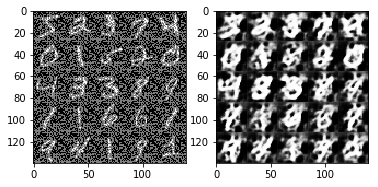

dis_loss: 1.30626822, en_loss: 1.61127448, recon_loss: 0.0086
dis_loss: 1.27171803, en_loss: 1.44795799, recon_loss: 0.0072
dis_loss: 1.18718839, en_loss: 1.59594941, recon_loss: 0.0078
dis_loss: 1.45497394, en_loss: 1.53010917, recon_loss: 0.0094
dis_loss: 1.31673884, en_loss: 1.48815966, recon_loss: 0.0075
dis_loss: 1.33065844, en_loss: 1.46120965, recon_loss: 0.0080
dis_loss: 1.35861611, en_loss: 1.61973846, recon_loss: 0.0092
dis_loss: 1.33686757, en_loss: 1.53791428, recon_loss: 0.0083
dis_loss: 1.18115151, en_loss: 1.64319587, recon_loss: 0.0085
dis_loss: 1.30167842, en_loss: 1.38280129, recon_loss: 0.0067
######### what? the reconstruction mse is: 0.4622


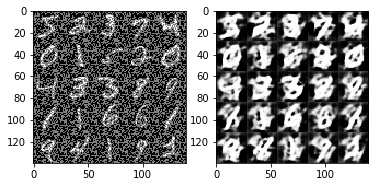

dis_loss: 1.26168859, en_loss: 1.54275823, recon_loss: 0.0081
dis_loss: 1.32307136, en_loss: 1.61362767, recon_loss: 0.0092
dis_loss: 1.36573315, en_loss: 1.49309134, recon_loss: 0.0081
dis_loss: 1.21709991, en_loss: 1.65191698, recon_loss: 0.0091
dis_loss: 1.70873177, en_loss: 1.20927000, recon_loss: 0.0075
dis_loss: 1.35605884, en_loss: 1.54823864, recon_loss: 0.0077
dis_loss: 1.34247994, en_loss: 1.34661055, recon_loss: 0.0067
dis_loss: 1.41406393, en_loss: 1.43803263, recon_loss: 0.0072
dis_loss: 1.10748446, en_loss: 1.85023713, recon_loss: 0.0094
dis_loss: 1.19887590, en_loss: 1.50108790, recon_loss: 0.0078
######### what? the reconstruction mse is: 0.3790


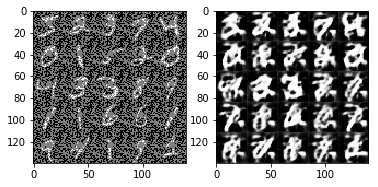

dis_loss: 1.22071552, en_loss: 1.62203062, recon_loss: 0.0086
dis_loss: 1.29574251, en_loss: 1.66924477, recon_loss: 0.0097
dis_loss: 1.43022442, en_loss: 1.52826476, recon_loss: 0.0084
dis_loss: 1.39768600, en_loss: 1.40330124, recon_loss: 0.0071
dis_loss: 1.20976138, en_loss: 1.61454391, recon_loss: 0.0076
dis_loss: 1.24348807, en_loss: 1.63996816, recon_loss: 0.0095
dis_loss: 1.07500970, en_loss: 1.56472099, recon_loss: 0.0078
dis_loss: 1.37009120, en_loss: 1.49971056, recon_loss: 0.0082
dis_loss: 1.32622135, en_loss: 1.51034355, recon_loss: 0.0079
dis_loss: 1.27824020, en_loss: 1.52711260, recon_loss: 0.0076
######### what? the reconstruction mse is: 0.3096


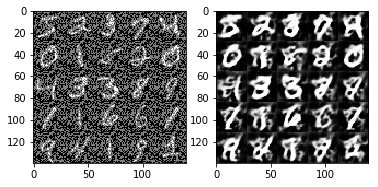

dis_loss: 1.30870318, en_loss: 1.42088652, recon_loss: 0.0074
dis_loss: 1.46303749, en_loss: 1.33326197, recon_loss: 0.0070
dis_loss: 1.45354652, en_loss: 1.43539882, recon_loss: 0.0078
dis_loss: 1.22407889, en_loss: 1.54696321, recon_loss: 0.0079
dis_loss: 1.31636536, en_loss: 1.41922998, recon_loss: 0.0076
dis_loss: 1.20364583, en_loss: 1.64430618, recon_loss: 0.0081
dis_loss: 1.50921297, en_loss: 1.27832627, recon_loss: 0.0062
dis_loss: 1.39638591, en_loss: 1.45003748, recon_loss: 0.0077
dis_loss: 1.18623734, en_loss: 1.44439399, recon_loss: 0.0070
dis_loss: 1.54828405, en_loss: 1.33520603, recon_loss: 0.0069
######### what? the reconstruction mse is: 0.3802


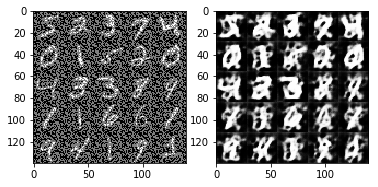

dis_loss: 1.19367075, en_loss: 1.65139782, recon_loss: 0.0078
dis_loss: 1.08571959, en_loss: 1.66082549, recon_loss: 0.0076
dis_loss: 1.37065971, en_loss: 1.33229208, recon_loss: 0.0077
dis_loss: 1.93685985, en_loss: 1.25873995, recon_loss: 0.0085
dis_loss: 1.31480193, en_loss: 1.55128288, recon_loss: 0.0072
dis_loss: 1.41962600, en_loss: 1.54756510, recon_loss: 0.0091
dis_loss: 1.33315992, en_loss: 1.67344379, recon_loss: 0.0090
dis_loss: 1.25685096, en_loss: 1.53674579, recon_loss: 0.0078
dis_loss: 1.46825552, en_loss: 1.43340206, recon_loss: 0.0078
dis_loss: 1.44296718, en_loss: 1.56638336, recon_loss: 0.0076
######### what? the reconstruction mse is: 0.2761


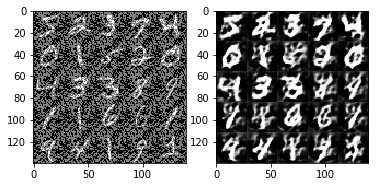

dis_loss: 1.16085267, en_loss: 1.72359920, recon_loss: 0.0091
dis_loss: 1.38287151, en_loss: 1.48022556, recon_loss: 0.0086
dis_loss: 1.37724006, en_loss: 1.30397987, recon_loss: 0.0068
dis_loss: 1.24948788, en_loss: 1.59446239, recon_loss: 0.0081
dis_loss: 1.46682787, en_loss: 1.41140926, recon_loss: 0.0078
dis_loss: 1.18121874, en_loss: 1.60286880, recon_loss: 0.0080
dis_loss: 1.32258821, en_loss: 1.58492613, recon_loss: 0.0085
dis_loss: 1.30908823, en_loss: 1.52389550, recon_loss: 0.0080
dis_loss: 1.28476906, en_loss: 1.39409947, recon_loss: 0.0068
dis_loss: 1.49825132, en_loss: 1.39109778, recon_loss: 0.0081
######### what? the reconstruction mse is: 0.4144


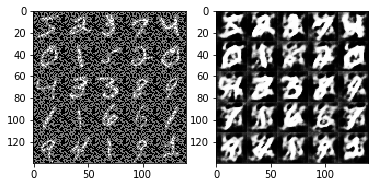

dis_loss: 1.27845442, en_loss: 1.55614948, recon_loss: 0.0073
dis_loss: 1.67803013, en_loss: 1.38459253, recon_loss: 0.0084
dis_loss: 1.08216190, en_loss: 1.65852284, recon_loss: 0.0074
dis_loss: 1.27282810, en_loss: 1.59713554, recon_loss: 0.0084
dis_loss: 1.54631615, en_loss: 1.41962087, recon_loss: 0.0081
dis_loss: 1.43327248, en_loss: 1.46819818, recon_loss: 0.0074
dis_loss: 1.35872066, en_loss: 1.42892015, recon_loss: 0.0076
dis_loss: 1.35515141, en_loss: 1.41568661, recon_loss: 0.0074
dis_loss: 1.27475893, en_loss: 1.51341605, recon_loss: 0.0082
dis_loss: 1.53345358, en_loss: 1.60415363, recon_loss: 0.0094
######### what? the reconstruction mse is: 0.4834


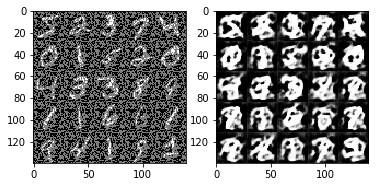

dis_loss: 1.20445037, en_loss: 1.76610255, recon_loss: 0.0085
dis_loss: 1.26129365, en_loss: 1.64877462, recon_loss: 0.0080
dis_loss: 1.19802856, en_loss: 1.48548627, recon_loss: 0.0071
dis_loss: 1.20443416, en_loss: 1.60614657, recon_loss: 0.0075
dis_loss: 1.38453627, en_loss: 1.55119586, recon_loss: 0.0080
dis_loss: 1.45418370, en_loss: 1.44312310, recon_loss: 0.0077
dis_loss: 1.33154905, en_loss: 1.56309557, recon_loss: 0.0068
dis_loss: 1.12662077, en_loss: 1.68398857, recon_loss: 0.0083
dis_loss: 1.41273642, en_loss: 1.36047196, recon_loss: 0.0070
dis_loss: 1.23072219, en_loss: 1.49480224, recon_loss: 0.0074
######### what? the reconstruction mse is: 0.3923


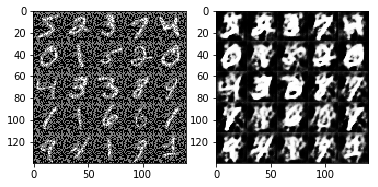

dis_loss: 1.10884261, en_loss: 1.67181396, recon_loss: 0.0088
dis_loss: 1.23353815, en_loss: 1.49596381, recon_loss: 0.0074
dis_loss: 1.19247556, en_loss: 1.54219484, recon_loss: 0.0075
dis_loss: 1.21767843, en_loss: 1.37887549, recon_loss: 0.0063
dis_loss: 1.32156646, en_loss: 1.57915807, recon_loss: 0.0087
dis_loss: 1.40773916, en_loss: 1.64866996, recon_loss: 0.0089
dis_loss: 1.16482735, en_loss: 1.49620032, recon_loss: 0.0073
dis_loss: 1.13492024, en_loss: 1.51557720, recon_loss: 0.0080
dis_loss: 1.19962740, en_loss: 1.50280881, recon_loss: 0.0076
dis_loss: 1.37516117, en_loss: 1.55502439, recon_loss: 0.0077
######### what? the reconstruction mse is: 0.4143


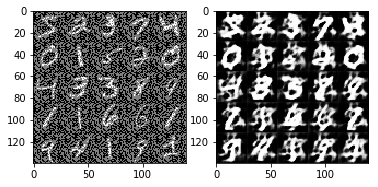

dis_loss: 1.32935286, en_loss: 1.95727587, recon_loss: 0.0113
dis_loss: 1.33837795, en_loss: 1.51567435, recon_loss: 0.0082
dis_loss: 1.46188021, en_loss: 1.38951302, recon_loss: 0.0071
dis_loss: 1.39751387, en_loss: 1.44575357, recon_loss: 0.0072
dis_loss: 1.35835958, en_loss: 1.54378796, recon_loss: 0.0083
dis_loss: 1.09160805, en_loss: 1.70875418, recon_loss: 0.0079
dis_loss: 1.36699939, en_loss: 1.37326884, recon_loss: 0.0068
dis_loss: 1.30891371, en_loss: 1.47220421, recon_loss: 0.0076
dis_loss: 1.37521362, en_loss: 1.51927495, recon_loss: 0.0079
dis_loss: 1.40004086, en_loss: 1.43701828, recon_loss: 0.0079
######### what? the reconstruction mse is: 0.3543


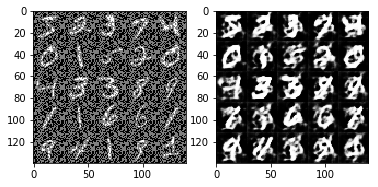

dis_loss: 1.17728364, en_loss: 1.50031948, recon_loss: 0.0068
dis_loss: 1.19956017, en_loss: 1.39287639, recon_loss: 0.0062
dis_loss: 1.23734570, en_loss: 1.58313012, recon_loss: 0.0077
dis_loss: 1.36218345, en_loss: 1.28173184, recon_loss: 0.0062
dis_loss: 1.49848866, en_loss: 1.64335120, recon_loss: 0.0087
dis_loss: 1.34553707, en_loss: 1.59142458, recon_loss: 0.0084
dis_loss: 1.35855365, en_loss: 1.40469646, recon_loss: 0.0072
dis_loss: 1.37207890, en_loss: 1.38211942, recon_loss: 0.0073
dis_loss: 1.20726728, en_loss: 1.66518438, recon_loss: 0.0086
dis_loss: 1.19327474, en_loss: 1.60676694, recon_loss: 0.0086
######### what? the reconstruction mse is: 0.4144


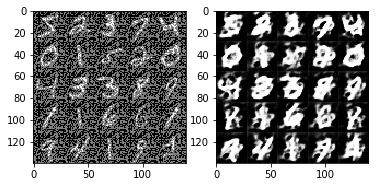

dis_loss: 1.25752711, en_loss: 1.61473894, recon_loss: 0.0084
dis_loss: 1.19921708, en_loss: 1.51649117, recon_loss: 0.0077
dis_loss: 1.46216941, en_loss: 1.45659399, recon_loss: 0.0081
dis_loss: 1.51253653, en_loss: 1.48673069, recon_loss: 0.0085
dis_loss: 1.30584192, en_loss: 1.44407749, recon_loss: 0.0073
dis_loss: 1.22707880, en_loss: 1.79681408, recon_loss: 0.0095
dis_loss: 1.16932476, en_loss: 1.68184519, recon_loss: 0.0086
dis_loss: 1.68495822, en_loss: 1.22891343, recon_loss: 0.0069
dis_loss: 1.26304960, en_loss: 1.78692424, recon_loss: 0.0085
dis_loss: 1.25406933, en_loss: 1.68934166, recon_loss: 0.0093
######### what? the reconstruction mse is: 0.3831


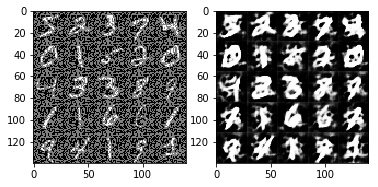

dis_loss: 1.25337100, en_loss: 1.57352865, recon_loss: 0.0077
dis_loss: 1.49021268, en_loss: 1.46117401, recon_loss: 0.0087
dis_loss: 1.16084361, en_loss: 2.38248324, recon_loss: 0.0142
dis_loss: 1.06804740, en_loss: 1.77711999, recon_loss: 0.0091


In [63]:
batch_size = 32
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
M = 1
z_dim = 1024
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
sample_set = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[:25])
sample_images = next(sample_set.get_batches(25))

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[25:])

print(mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, beta2, M, mnist_dataset.get_batches, 
         sample_images, mnist_dataset.shape, mnist_dataset.image_mode)


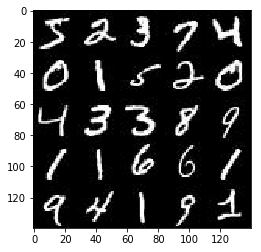

In [21]:
cmap = 'gray'
sample_images_grid = helper.images_square_grid(sample_images, mnist_dataset.image_mode)
pyplot.imshow(sample_images_grid, cmap=cmap)
pyplot.show()